In [1]:
import logging
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

import os
import sys
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

sys.path.append('/Data/reds_dataset/6.8300-Computer-Vision/src/')

from data_handlers.loading import MultiStageVideoDataset
from models import MultiStageBasicVSR
from utils.loss import CharbonnierLoss
from utils.logging_config import logger_setup
from utils.arguments_parser import args_parser
from config import return_config
from utils.tester_multistage import test_loop
from utils.trainer_multistage import train_loop

/Data/reds_dataset/6.8300-Computer-Vision/src/models/optical_flow/util.py:10: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


In [2]:
val_dataset = MultiStageVideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=True,
        is_small_test=True,
        patch_size=64,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

model = MultiStageBasicVSR(
        spynet_pretrained='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/spynet_20210409-c6c1bd09.pth',
        pretrained_model='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/basicvsr_custom_spynet.pth',
        num_heads=4,
        rolling_window=5,
    )

state_dict = torch.load('/Data/reds_dataset/6.8300-Computer-Vision/results/multistage_bvsr_trial1/models/model_10.pth')
state_dict = {k.replace('_orig_mod.',''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to('cuda')
model = model.eval()

In [16]:
device = 'cuda'
for idx, data in enumerate(val_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))
    out, base, res, bvsr = model((in_1, in_2, in_3))
    break

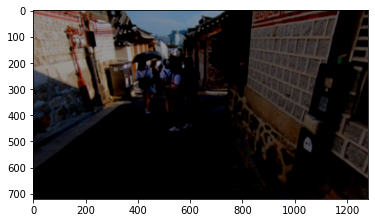

In [7]:
# print out as image
out = out.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
out = np.clip(out, 0, 1)
plt.imshow(out)

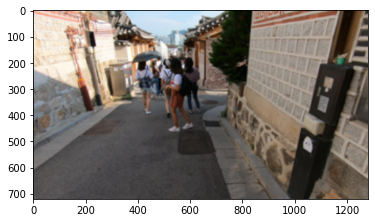

In [13]:
base = base.squeeze().permute(1, 2, 0).cpu().detach().numpy()
base = np.clip(base, 0, 1)
plt.imshow(base)

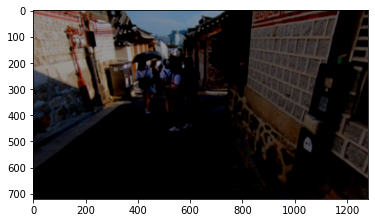

In [14]:
res = res.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
res = np.clip(res, 0, 1)
plt.imshow(res)

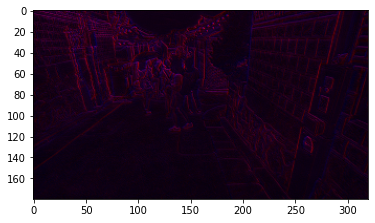

In [18]:
bvsr = bvsr.squeeze(0)[0:3,:,:].permute(1, 2, 0).cpu().detach().numpy()
bvsr = np.clip(bvsr, 0, 1)
plt.imshow(bvsr)

In [17]:
bvsr.shape

torch.Size([1, 64, 180, 320])